# Data Import

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
%matplotlib inline 

In [2]:
# Mount Google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Load data
reviews = pd.read_csv('/content/drive/My Drive/DMA_final_project/winemag-data_first150k.csv')
display(reviews.head())
# Post geo coding file
winery_df = pd.read_csv('/content/drive/My Drive/DMA_final_project/winery_geo_info.csv')
winery_df.head()

Unnamed: 0 country  ...             variety                   winery
0           0      US  ...  Cabernet Sauvignon                    Heitz
1           1   Spain  ...       Tinta de Toro  Bodega Carmen Rodríguez
2           2      US  ...     Sauvignon Blanc                 Macauley
3           3      US  ...          Pinot Noir                    Ponzi
4           4  France  ...  Provence red blend     Domaine de la Bégude

[5 rows x 11 columns]

Unnamed: 0  ...          status
0           0  ...              OK
1           1  ...    ZERO_RESULTS
2           2  ...              OK
3           3  ...              OK
4           4  ...  REQUEST_DENIED

[5 rows x 11 columns]

# WINE Review preprocessing for geocoding

In [4]:
# Unique province,region_1,region_2 count
unique_province = reviews['province'].value_counts()
unique_region1, unique_region2 = reviews['region_1'].value_counts(),reviews['region_2'].value_counts()
print(len(unique_province),len(unique_region1),len(unique_region2))


455 1236 18


In [5]:
# Make Address Column for geo coding
reviews['combined_region'] = reviews.region_2.combine_first(reviews.region_1)
reviews['province_country'] = reviews.province.str.cat(reviews.country,sep =", ")
reviews['Address'] = reviews.combined_region.str.cat(reviews.province_country,sep =", ")
reviews['Address'] = reviews.Address.combine_first(reviews.province_country)
reviews['Address'] = reviews.winery.str.cat(reviews.Address,sep = ', ')
reviews.head()

Unnamed: 0  ...                                            Address
0           0  ...                        Heitz, Napa, California, US
1           1  ...  Bodega Carmen Rodríguez, Toro, Northern Spain,...
2           2  ...                   Macauley, Sonoma, California, US
3           3  ...               Ponzi, Willamette Valley, Oregon, US
4           4  ...     Domaine de la Bégude, Bandol, Provence, France

[5 rows x 14 columns]

In [0]:
# # MAKE csv file for geo coding No need to run after obtained geocoded data

# processing_file = reviews.loc[:,['Address']].drop_duplicates()
# print(len(processing_file))
# # processing_file['index'] = processing_file.index
# processing_file.to_csv('address_for_geocode.csv')

In [7]:
# Combine two tables and drop unneccsary columns
winery_df = winery_df.loc[:,['input_string','latitude','longitude']]
reviews = reviews.merge(winery_df,how = 'left', left_on='Address',right_on='input_string')
to_drop = ['combined_region','province_country','Address','input_string']
reviews = reviews.drop(to_drop,axis = 1)
reviews.head()

Unnamed: 0 country  ...   latitude   longitude
0           0      US  ...  38.490688 -122.450859
1           1   Spain  ...        NaN         NaN
2           2      US  ...  38.505243 -122.470387
3           3      US  ...  45.379740 -122.936346
4           4  France  ...        NaN         NaN

[5 rows x 13 columns]

In [8]:
# Check number of Null values on in long and latitude values
reviews[['latitude']].isnull().sum()/len(reviews)

# Only 2.5% of geo data are missing, I think geocoding did fiarly good job

latitude    0.025111
dtype: float64

In [9]:
# drop missing value
winery_geo_df = reviews[['points','price','longitude','latitude']]
winery_geo_df = winery_geo_df.dropna(subset = ['longitude', 'latitude'])
winery_geo_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 147140 entries, 0 to 150929
Data columns (total 4 columns):
points       147140 non-null int64
price        133806 non-null float64
longitude    147140 non-null float64
latitude     147140 non-null float64
dtypes: float64(3), int64(1)
memory usage: 5.6 MB


In [10]:
# Isolate california geo data

cali_df = reviews.loc[reviews.province == 'California']
# filter out extreme data that may due to geocoding error...
cali_df = cali_df[cali_df['longitude'] < cali_df['longitude'].quantile(0.95)]
cali_df = cali_df[cali_df['latitude'] < cali_df['latitude'].quantile(0.95)]
cali_df.describe()

Unnamed: 0        points         price      latitude     longitude
count   36810.000000  36810.000000  36678.000000  36810.000000  36810.000000
mean    77606.252839     87.964792     37.419598     37.872049   -122.053007
std     43571.027733      3.515467     28.621151      1.168267      0.836573
min         0.000000     80.000000      4.000000     34.407695   -123.649333
25%     40568.250000     85.000000     20.000000     38.086227   -122.542716
50%     79320.500000     88.000000     30.000000     38.364079   -122.390093
75%    115774.500000     91.000000     45.000000     38.493681   -121.571940
max    150916.000000    100.000000   2013.000000     39.213777   -119.466422

# Data Visualization

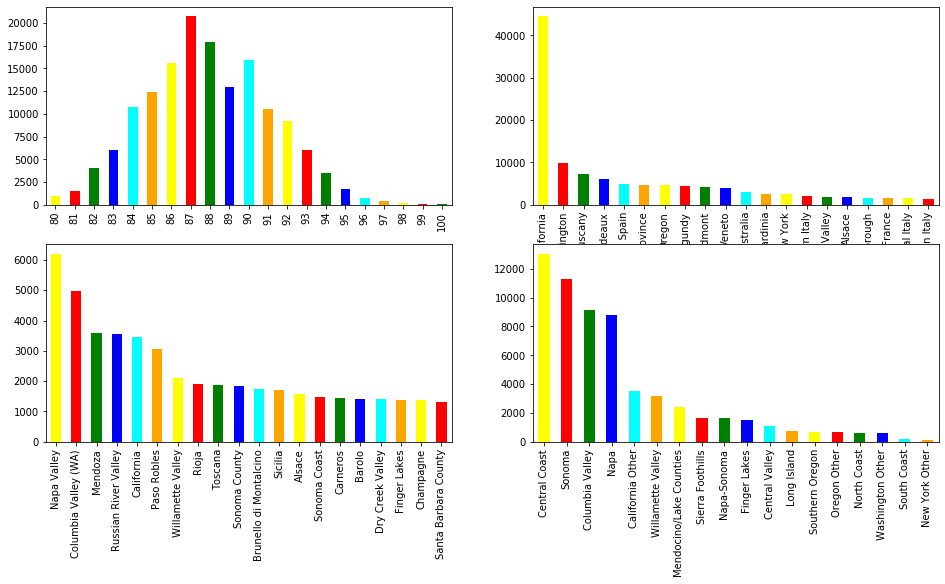

In [12]:
# Rating, state or province and region distributions 
fig, axarr = plt.subplots(2, 2, figsize=(16, 8))

reviews['points'].value_counts().sort_index().plot.bar(ax=axarr[0][0],color=['yellow', 'red', 'green', 'blue', 'cyan','orange'])
reviews['province'].value_counts().head(20).plot.bar(ax=axarr[0][1],color=['yellow', 'red', 'green', 'blue', 'cyan','orange'])
reviews['region_1'].value_counts().head(20).plot.bar(ax=axarr[1][0],color=['yellow', 'red', 'green', 'blue', 'cyan','orange'])
reviews['region_2'].value_counts().head(20).plot.bar(ax=axarr[1][1],color=['yellow', 'red', 'green', 'blue', 'cyan','orange'])


In [21]:
!apt install proj-bin libproj-dev libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/v1.1.0.tar.gz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
Suggested packages:
  libgdal-doc
The following NEW packages will be installed:
  libgeos-dev libproj-dev proj-bin
0 upgraded, 3 newly installed, 0 to remove and 32 not upgraded.
Need to get 305 kB of archives.
After this operation, 1,706 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libgeos-dev amd64 3.6.2-1build2 [73.1 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libproj-dev amd64 4.9.3-2 [199 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 proj-bin amd64 4.9.3-2 [32.3 kB]
Fetched 305 kB in 1s (268 kB/s)
Selecting previously unselected package libgeos-dev.
(Reading database ... 145605 files and directories currently installed.)
Preparing to unpack .../libgeos-dev_3

In [22]:
!pip install git+https://github.com/python-visualization/folium

  Cloning https://github.com/python-visualization/folium to /tmp/pip-req-build-ogp4tp51
  Running command git clone -q https://github.com/python-visualization/folium /tmp/pip-req-build-ogp4tp51
  Created wheel for folium: filename=folium-0.10.1-py2.py3-none-any.whl size=91328 sha256=02caac4b51bb482b4f1cfc4a2eb3c424e5b0065024ed73909a98f5c326c5cb84
  Stored in directory: /tmp/pip-ephem-wheel-cache-k4ed8i29/wheels/1e/e1/75/ecbc91fd5dd5d90befb0b533bf7492d38acffa033310731862
Successfully built folium


In [23]:
# Update basemap PASSWORD Required
!pip install -U git+https://github.com/matplotlib/basemap.git

  Cloning https://github.com/matplotlib/basemap.git to /tmp/pip-req-build-_2851w02
  Running command git clone -q https://github.com/matplotlib/basemap.git /tmp/pip-req-build-_2851w02
  Created wheel for basemap: filename=basemap-1.2.1-cp36-cp36m-linux_x86_64.whl size=121756047 sha256=66c7db7a9133cdaccdf32884e4fb64612d2059375dbca51e82f4f8aa858c5099
  Stored in directory: /tmp/pip-ephem-wheel-cache-gr472xaz/wheels/3f/f3/56/de548b66967d0d661612b7618022e2c0d4b86b9a638cf6ccf3
Successfully built basemap
  Found existing installation: basemap 1.1.0
    Uninstalling basemap-1.1.0:
      Successfully uninstalled basemap-1.1.0


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


http://server.arcgisonline.com/ArcGIS/rest/services/NatGeo_World_Map/MapServer/export?bbox=1461251.4884882858,594181.265869036,1890579.9437951348,1157466.0434603156&bboxSR=2770&imageSR=2770&size=1500,1968&dpi=96&format=png32&transparent=true&f=image


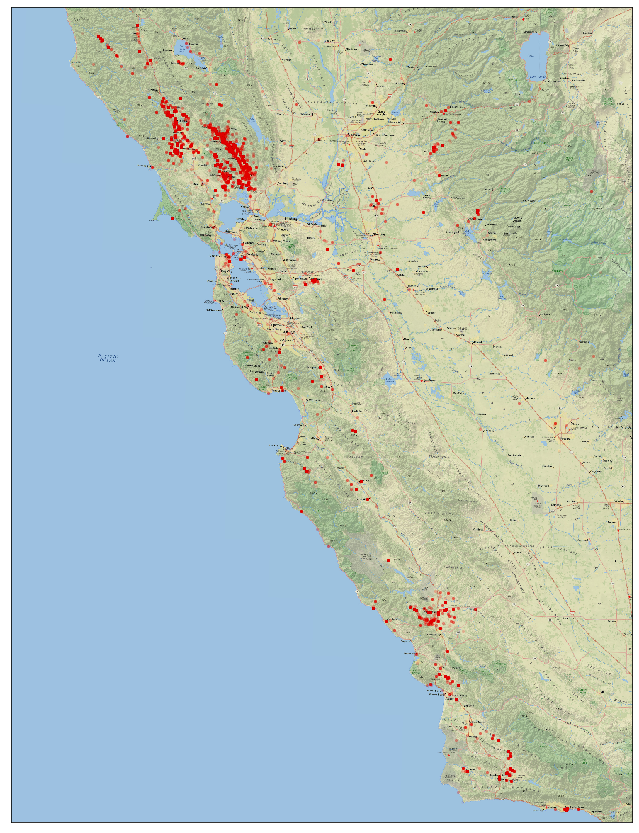

In [11]:
from mpl_toolkits.basemap import Basemap
import folium
m = Basemap(projection='mill',llcrnrlat=cali_df.latitude.min()-0.2,urcrnrlat=cali_df.latitude.max() + 0.2,
            llcrnrlon=cali_df.longitude.min()-0.2,urcrnrlon=cali_df.longitude.max()+0.2,resolution="c",epsg=2770)
x,y= m(tuple(cali_df.longitude),tuple(cali_df.latitude))

plt.figure(figsize=(20,15))
m.arcgisimage(service="NatGeo_World_Map",xpixels=1500,verbose=True)
m.plot(x,y,'ro',markersize=2,alpha=0.03)

In [12]:
from folium import plugins
from folium.plugins import HeatMap
bay_area_co = [37.8272, -122.2913]
map_heat= folium.Map(location=bay_area_co,zoom_start = 8)
heat_data = cali_df[['latitude','longitude']]
HeatMap(heat_data,radius=10).add_to(map_heat)
map_heat

It's not surprising Napa and Sonoma region is the largest winery region in California, but do what about the second and third? It seems the map is pointing to Santa Barbara region and southern California region. Let's try to verify if that's true.


In [13]:
cali_region = cali_df.groupby('region_1').size().sort_values(ascending=False).rename("counts").reset_index()
#display(cali_region[:20])

# Some of the names I don't really know which area they are actually located. Let's assign some labels
# arbitary diving latitude 
cali_lat_mid = 36.5
cali_region_1 = cali_df.groupby('region_1').mean().reset_index()
cali_region_1['NS'] = 'Northern California'
cali_region_1.loc[cali_region_1['latitude'] < cali_lat_mid,'NS'] = 'Southern California'
cali_region_1 = cali_region_1[['region_1','NS']]

# Merge
cali_region = cali_region.merge(cali_region_1,how='left', on = 'region_1')
cali_region.head(5)


region_1  counts                   NS
0           Napa Valley    5972  Northern California
1  Russian River Valley    3464  Northern California
2           Paso Robles    2491  Southern California
3         Sonoma County    1798  Northern California
4            California    1741  Northern California

The largest Non-Napa winery is actually located in Paso Robles, which I had no prior knowledge about. What kind of wine in terms of grape does California produce the most? 

In [14]:
var_df = cali_df.groupby('variety').size().sort_values(ascending=False).rename("counts").reset_index()
var_df.head()

variety  counts
0  Cabernet Sauvignon    6587
1          Pinot Noir    6459
2          Chardonnay    5534
3           Zinfandel    2909
4               Syrah    2183

Ok... That was something, I kind of know what to expect but what about a state or place I don't know much about? For instance, New York. It's listed number 13 in the dataset in terms of province but I rarely know anything about the geolocations of their wineries.

New York Graph

In [0]:
# Isolate New York geo data
ny_df = reviews.loc[reviews.province == 'New York']
# filter out extreme data that may due to geocoding error...
ny_df = ny_df[ny_df['longitude'] < ny_df['longitude'].quantile(0.975)]
ny_df = ny_df[ny_df['latitude'] < ny_df['latitude'].quantile(0.975)]
ny_df = ny_df[ny_df['latitude'] > ny_df['latitude'].quantile(0.025)]
ny_df.describe()

In [0]:
from folium import plugins
from folium.plugins import HeatMap
ny_co = [43.0481, -76.1474]
map_heat= folium.Map(location=ny_co,zoom_start = 6)
heat_data = ny_df[['latitude','longitude']]
HeatMap(heat_data,radius=10).add_to(map_heat)
map_heat

In [0]:
# Top winery and region
display(ny_df.winery.value_counts()[:5])
display(ny_df.region_1.value_counts()[:5])

# Top grape type
var_df = ny_df.groupby('variety').size().sort_values(ascending=False).rename("counts").reset_index()
var_df.head()


It seems most wineries are located around Finger Lake and North Fork of Long Island area and its most frequently produced wine is Riesling. This may have something to do with the grape's intrinstic tolerance in rather colder weather conditions. 

France and Italy Graph

In [0]:
# Isolate New York geo data
ItFr_df = reviews.loc[(reviews.country == 'Italy') | (reviews.country == 'France')]
ItFr_df = ItFr_df[ItFr_df['longitude'] < ItFr_df['longitude'].quantile(0.975)]
ItFr_df = ItFr_df[ItFr_df['longitude'] > ItFr_df['longitude'].quantile(0.05)]
ItFr_df = ItFr_df[ItFr_df['latitude'] < ItFr_df['latitude'].quantile(0.975)]
ItFr_df = ItFr_df[ItFr_df['latitude'] > ItFr_df['latitude'].quantile(0.05)]
ItFr_df.describe()

In [0]:
# Italy and France Heatmap
ItFr_co = [44.837789, 7.4246]
map_heat= folium.Map(location=ItFr_co,zoom_start = 6)
heat_data = ItFr_df[['latitude','longitude']]
HeatMap(heat_data,radius=10).add_to(map_heat)
map_heat

In [0]:
# Top winery and region
display(ItFr_df.winery.value_counts()[:5])
display(ItFr_df.region_1.value_counts()[:5])

# Top grape type
var_df = ItFr_df.groupby('variety').size().sort_values(ascending=False).rename("counts").reset_index()
var_df.head()


Seems like Chardonnay is the only common shared grape among all three regions. Additionally, it seems like red wine domainates a large portion of wine products in these two country.

In [0]:
# heatamp data based on price and points
pr_df = reviews[['latitude','longitude','price']].dropna()
pts_df = reviews[['latitude','longitude','points']].dropna()

# heatamp data coordinates
pts_co = [pts_df.latitude.mean(),pts_df.longitude.mean()]
pr_co = [pr_df.latitude.mean(),pr_df.longitude.mean()]

#pts_df.info()

In [16]:
# World heatmap based on points
# folium heatmap seems to have a cap on how many data points we can graph...
map_heat= folium.Map(location=pts_co,zoom_start = 2)
pts_df = pts_df.sort_values(by='points',ascending= False)
#map_heat.add_child(HeatMap(pts_df, radius = 10, gradient={.4: 'blue', .65: 'lime', 1: 'red'}))
HeatMap(pts_df.iloc[0:40000,:],radius=10, gradient={.4: 'blue', .65: 'lime', 1: 'red'}).add_to(map_heat)
map_heat

In [17]:
# World heatmap based on price
# folium heatmap seems to have a cap on how many data points we can graph...
map_heat= folium.Map(location=pr_co,zoom_start = 2)
pr_df = pr_df.sort_values(by='price',ascending= False)
#map_heat.add_child(HeatMap(pts_df, radius = 10, gradient={.4: 'blue', .65: 'lime', 1: 'red'}))
HeatMap(pr_df.iloc[0:40000,:],radius=10, gradient={.4: 'blue', .65: 'lime', 1: 'red'}).add_to(map_heat)
map_heat

In [0]:
# create a dataframe that focuses on VALUE (Points per dollar spent)
reviews['Pts_over_price'] = reviews['points']/reviews['price']
pp_df = reviews[['latitude','longitude','Pts_over_price']].dropna()
pp_df = pp_df.sort_values(by='Pts_over_price',ascending= False)


In [19]:
# World heatmap based on points
# folium heatmap seems to have a cap on how many data points we can graph...
map_heat= folium.Map(location=pts_co,zoom_start = 2)
#map_heat.add_child(HeatMap(pts_df, radius = 10, gradient={.4: 'blue', .65: 'lime', 1: 'red'}))
HeatMap(pp_df.iloc[0:30000,:],radius=10, gradient={.4: 'blue', .65: 'lime',0.95: 'red'}).add_to(map_heat)
map_heat

In [0]:
pp_df = pp_df.sort_values(by='Pts_over_price',ascending= False)

latitude   longitude  Pts_over_price
99045   38.748219   -9.139173       21.500000
48655   37.242177 -119.538251       21.500000
80185   37.242177 -119.538251       21.500000
25645   37.242177 -119.538251       21.500000
126595  37.242177 -119.538251       21.500000
...           ...         ...             ...
34942   44.816652   -0.608612        0.080000
34939   45.213075   -0.769852        0.073846
34922   45.044430   -0.668757        0.051579
13318   38.392780 -121.571940        0.045206
34920   45.175475   -0.745095        0.043043

[133806 rows x 3 columns]